In [181]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import calinski_harabasz_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from xgboost import XGBRegressor, XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.svm import SVR
from statistics import mean
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
import seaborn as sns
import xgboost as xgb
import pandas as pd
import arviz as az
import numpy as np
import arviz as az
import pymc as pm
import sqlite3
import joblib
import random 
import math
import os

In [182]:
col_order = ['Player', 'Team', 'Season', 'Age', 'G', 'PA', 'AB',
       'R', 'H', '1B', '2B', '3B', 'HR', 'RBI', 'XBH', 'SB', 'CS', 'BB', 'SO', 'BA',
       'OBP', 'SLG', 'OPS', 'TB', 'GIDP', 'HBP', 'SH', 'SF', 'IBB',
       'WAR', 'GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs', 'Pos', 'status']

inactive_data = pd.read_csv('inactive_player_data.csv')
inactive_data = inactive_data[col_order]
active_data = pd.read_csv('new_active_player_data.csv')
active_data = active_data[col_order]

In [183]:
inactive_data

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,SF,IBB,WAR,GGs,SSs,Bat_Titles,All_Stars,MVPs,Pos,status
0,Adam Jones,ARI,14,33,137,528,485,66,126,84,...,3.0,2.0,-0.7,0,0,0,0,0,9,retired
1,Adam Jones,BAL,3,22,132,514,477,61,129,92,...,5.0,0.0,2.0,0,0,0,0,0,8,retired
2,Adam Jones,BAL,4,23,119,519,473,83,131,87,...,3.0,3.0,2.6,1,0,0,1,0,8,retired
3,Adam Jones,BAL,5,24,149,621,581,76,165,116,...,2.0,1.0,2.5,0,0,0,0,0,8,retired
4,Adam Jones,BAL,6,25,151,618,567,68,159,106,...,12.0,2.0,3.3,0,0,0,0,0,8,retired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5207,Édgar Rentería,STL,5,23,150,643,562,94,156,107,...,9.0,3.0,2.2,0,1,0,0,0,6,retired
5208,Édgar Rentería,STL,6,24,141,549,493,54,128,96,...,6.0,4.0,1.5,0,0,0,0,0,6,retired
5209,Édgar Rentería,STL,7,25,152,609,544,77,166,117,...,5.0,7.0,4.3,1,1,0,0,0,6,retired
5210,Édgar Rentería,STL,8,26,157,663,587,96,194,133,...,7.0,12.0,5.6,1,1,0,0,0,6,retired


In [184]:
active_data

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,SF,IBB,WAR,GGs,SSs,Bat_Titles,All_Stars,MVPs,Pos,status
0,Christian Yelich,MIA,1,21,62,273,240,34,69,52,...,1,1,1.6,0,0,0,0,0,7,active
1,Christian Yelich,MIA,2,22,144,660,582,94,165,120,...,2,3,3.8,1,0,0,0,0,7,active
2,Christian Yelich,MIA,3,23,126,525,476,63,143,104,...,0,2,3.6,0,0,0,0,0,7,active
3,Christian Yelich,MIA,4,24,155,659,578,78,172,110,...,5,4,4.9,0,1,0,0,0,7,active
4,Christian Yelich,MIA,5,25,156,695,602,100,170,114,...,6,4,3.7,0,0,0,0,0,8,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,José Abreu,CHW,5,31,128,553,499,68,132,73,...,6,7,2.1,0,1,0,1,0,3,active
1770,José Abreu,CHW,6,32,159,693,634,85,180,108,...,10,4,2.3,0,0,0,1,0,3,active
1771,José Abreu,CHW,7,33,60,262,240,43,76,42,...,1,1,2.7,0,1,0,0,1,3,active
1772,José Abreu,CHW,8,34,152,659,566,86,148,86,...,10,3,3.0,0,0,0,0,0,3,active


In [185]:
inactive_dummies = pd.get_dummies(inactive_data['Pos'], prefix='Pos')
temp_inact_stat = inactive_data['status']
inactive_data.drop(['Pos', 'status'], axis=1, inplace=True)
inactive_data = pd.concat([inactive_data, inactive_dummies, temp_inact_stat], axis=1)

active_dummies = pd.get_dummies(active_data['Pos'], prefix='Pos')
temp_act_stat = active_data['status']
active_data.drop(['Pos', 'status'], axis=1, inplace=True)
active_data = pd.concat([active_data, active_dummies, temp_act_stat], axis=1)

inactive_data = inactive_data[inactive_data['Pos_1'] != True]
active_data = active_data[active_data['Pos_1'] != True]
inactive_data.drop(['Pos_1'], axis=1, inplace=True)
active_data.drop(['Pos_1'], axis=1, inplace=True)

In [186]:
inactive_data

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,Pos_2,Pos_3,Pos_4,Pos_5,Pos_6,Pos_7,Pos_8,Pos_9,Pos_10,status
0,Adam Jones,ARI,14,33,137,528,485,66,126,84,...,False,False,False,False,False,False,False,True,False,retired
1,Adam Jones,BAL,3,22,132,514,477,61,129,92,...,False,False,False,False,False,False,True,False,False,retired
2,Adam Jones,BAL,4,23,119,519,473,83,131,87,...,False,False,False,False,False,False,True,False,False,retired
3,Adam Jones,BAL,5,24,149,621,581,76,165,116,...,False,False,False,False,False,False,True,False,False,retired
4,Adam Jones,BAL,6,25,151,618,567,68,159,106,...,False,False,False,False,False,False,True,False,False,retired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5207,Édgar Rentería,STL,5,23,150,643,562,94,156,107,...,False,False,False,False,True,False,False,False,False,retired
5208,Édgar Rentería,STL,6,24,141,549,493,54,128,96,...,False,False,False,False,True,False,False,False,False,retired
5209,Édgar Rentería,STL,7,25,152,609,544,77,166,117,...,False,False,False,False,True,False,False,False,False,retired
5210,Édgar Rentería,STL,8,26,157,663,587,96,194,133,...,False,False,False,False,True,False,False,False,False,retired


In [187]:
active_data

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,Pos_2,Pos_3,Pos_4,Pos_5,Pos_6,Pos_7,Pos_8,Pos_9,Pos_10,status
0,Christian Yelich,MIA,1,21,62,273,240,34,69,52,...,False,False,False,False,False,True,False,False,False,active
1,Christian Yelich,MIA,2,22,144,660,582,94,165,120,...,False,False,False,False,False,True,False,False,False,active
2,Christian Yelich,MIA,3,23,126,525,476,63,143,104,...,False,False,False,False,False,True,False,False,False,active
3,Christian Yelich,MIA,4,24,155,659,578,78,172,110,...,False,False,False,False,False,True,False,False,False,active
4,Christian Yelich,MIA,5,25,156,695,602,100,170,114,...,False,False,False,False,False,False,True,False,False,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,José Abreu,CHW,5,31,128,553,499,68,132,73,...,False,True,False,False,False,False,False,False,False,active
1770,José Abreu,CHW,6,32,159,693,634,85,180,108,...,False,True,False,False,False,False,False,False,False,active
1771,José Abreu,CHW,7,33,60,262,240,43,76,42,...,False,True,False,False,False,False,False,False,False,active
1772,José Abreu,CHW,8,34,152,659,566,86,148,86,...,False,True,False,False,False,False,False,False,False,active


In [188]:
for i in inactive_data.columns[2:44]:
    skew = inactive_data[i].skew()
    print(f'{i} skewness: {skew}')

Season skewness: 0.9943603714406879
Age skewness: 0.17427974366392981
G skewness: -1.4238072232539214
PA skewness: -1.093369250644647
AB skewness: -1.053047240985612
R skewness: -0.3186983429104098
H skewness: -0.6901117545366012
1B skewness: -0.3677206837982762
2B skewness: -0.05221911154006465
3B skewness: 1.6111001852634304
HR skewness: 0.6938805261295057
RBI skewness: -0.0032976818849739546
XBH skewness: -0.075501059500814
SB skewness: 2.4271469879872285
CS skewness: 1.7143319909394525
BB skewness: 0.49337552958844966
SO skewness: 0.24848040439879193
BA skewness: -1.0859354548542037
OBP skewness: -0.9439857124329137
SLG skewness: -0.21433344119033423
OPS skewness: -0.4949259616198078
TB skewness: -0.4760397077783871
GIDP skewness: 0.4504292912998146
HBP skewness: 2.546096079331244
SH skewness: 2.8540769866595808
SF skewness: 0.714848323278483
IBB skewness: 3.331110648503943
WAR skewness: 0.49560738929513615
GGs skewness: 2.2640742574278403
SSs skewness: 2.9192241265365255
Bat_Title

In [189]:
def fix_skew(df, col, min_abs_skew=0.5):
    skew = df[col].skew()
    abs_skew = abs(skew)
    
    if abs_skew <= min_abs_skew:
        return
    
    if skew < 0:
        max_val = df[col].max()
        df[col] = max_val - df[col] + 1 
        
    min_val = df[col].min()
    if min_val <= 0:
        offset = abs(min_val) + 1e-6
        df[col] = df[col] + offset
    
    if min_abs_skew <= abs_skew < 1.0:
        df[col] = np.sqrt(df[col])
    elif abs_skew >= 1.0:
        df[col] = np.log1p(df[col]) 

def fix_seasons(df):
    for player in df['Player'].unique():
        debut = df.loc[df['Player'] == player, 'Season'].min()
        df.loc[df['Player'] == player, 'Season'] = df.loc[df['Player'] == player, 'Season'] - debut + 1

def find_optimal_clusters(data, max_clusters=8):
    scores = []
    
    for k in range(2, max_clusters+1):
        gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
        clusters = gmm.fit_predict(data)
        score = silhouette_score(data, clusters)
        scores.append(score)
        print(f"Clusters: {k} - Silhouette: {score:.3f}")
    
    optimal_k = np.argmax(scores) + 2
    print(f"Optimal cluster count: {optimal_k}")
    return optimal_k

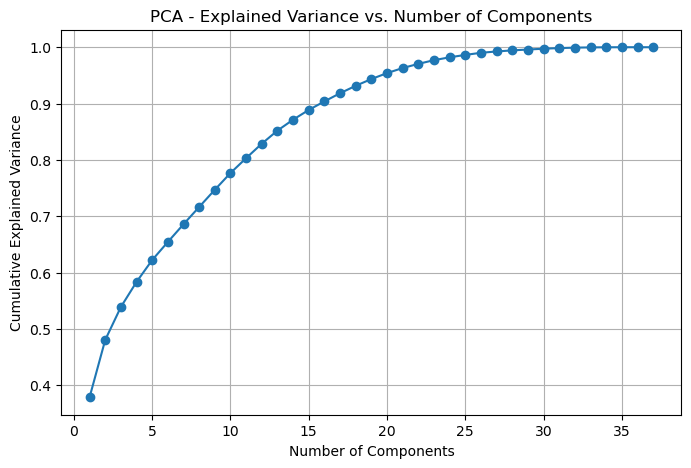

Component 1: 0.3789
Component 2: 0.4806
Component 3: 0.5391
Component 4: 0.5836
Component 5: 0.6224
Component 6: 0.6545
Component 7: 0.6859
Component 8: 0.7166
Component 9: 0.7471
Component 10: 0.7768
Component 11: 0.8032
Component 12: 0.8288
Component 13: 0.8521
Component 14: 0.8715
Component 15: 0.8887
Component 16: 0.9039
Component 17: 0.9184
Component 18: 0.9316
Component 19: 0.9435
Component 20: 0.9541
Component 21: 0.9631
Component 22: 0.9705
Component 23: 0.9771
Component 24: 0.9821
Component 25: 0.9864
Component 26: 0.9901
Component 27: 0.9925
Component 28: 0.9944
Component 29: 0.9959
Component 30: 0.9973
Component 31: 0.9984
Component 32: 0.9993
Component 33: 0.9997
Component 34: 0.9999
Component 35: 1.0000
Component 36: 1.0000
Component 37: 1.0000


In [190]:
test_inactive = inactive_data.copy()
test_inactive.drop(['GGs', 'SSs', 'Bat_Titles', 'All_Stars'], axis=1, inplace=True)

test_inactive_X = test_inactive[test_inactive.columns[2:39]].dropna()

for i in test_inactive_X.columns[2:31]:
    fix_skew(test_inactive_X, i)

test_inactive_X_scaled = StandardScaler().fit_transform(test_inactive_X)

test_pca = PCA()
test_pca.fit_transform(test_inactive_X_scaled)

explained_variance = test_pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Explained Variance vs. Number of Components")
plt.grid(True)
plt.show()

for i, var in enumerate(cumulative_variance):
    print(f"Component {i+1}: {var:.4f}")

In [191]:
test_inactive = inactive_data.copy()
test_inactive.drop(['GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs'], axis=1, inplace=True)

test_active = active_data.copy()
test_active.drop(['GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs'], axis=1, inplace=True)

test_inactive_X = test_inactive[test_inactive.columns[2:39]].dropna()
test_active_X = test_active[test_active.columns[2:39]].dropna()

for i in test_inactive_X.columns[2:31]:
    fix_skew(test_inactive_X, i)

for i in test_active_X.columns[2:31]:
    fix_skew(test_active_X, i)

pca = PCA(n_components=9)
inactive_X_pca = pca.fit_transform(test_inactive_X)
active_X_pca = pca.transform(test_active_X)

best_k = find_optimal_clusters(inactive_X_pca)

gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(inactive_X_pca)

cluster_probs_inactive = gmm.predict_proba(inactive_X_pca)
cluster_probs_active = gmm.predict_proba(active_X_pca)

Clusters: 2 - Silhouette: 0.476
Clusters: 3 - Silhouette: 0.294
Clusters: 4 - Silhouette: 0.217
Clusters: 5 - Silhouette: 0.146
Clusters: 6 - Silhouette: 0.163
Clusters: 7 - Silhouette: 0.137
Clusters: 8 - Silhouette: 0.133
Optimal cluster count: 2


In [192]:
for i in range(cluster_probs_inactive.shape[1]):
    test_inactive[f'Cluster_{i}_Prob'] = cluster_probs_inactive[:, i]

for i in range(cluster_probs_active.shape[1]):
    test_active[f'Cluster_{i}_Prob'] = cluster_probs_active[:, i]

In [193]:
test_inactive

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,Pos_4,Pos_5,Pos_6,Pos_7,Pos_8,Pos_9,Pos_10,status,Cluster_0_Prob,Cluster_1_Prob
0,Adam Jones,ARI,14,33,137,528,485,66,126,84,...,False,False,False,False,False,True,False,retired,0.992516,7.484315e-03
1,Adam Jones,BAL,3,22,132,514,477,61,129,92,...,False,False,False,False,True,False,False,retired,0.999221,7.790823e-04
2,Adam Jones,BAL,4,23,119,519,473,83,131,87,...,False,False,False,False,True,False,False,retired,0.999666,3.340533e-04
3,Adam Jones,BAL,5,24,149,621,581,76,165,116,...,False,False,False,False,True,False,False,retired,1.000000,7.854099e-09
4,Adam Jones,BAL,6,25,151,618,567,68,159,106,...,False,False,False,False,True,False,False,retired,0.999997,3.054060e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5207,Édgar Rentería,STL,5,23,150,643,562,94,156,107,...,False,False,True,False,False,False,False,retired,0.999977,2.264128e-05
5208,Édgar Rentería,STL,6,24,141,549,493,54,128,96,...,False,False,True,False,False,False,False,retired,0.821402,1.785984e-01
5209,Édgar Rentería,STL,7,25,152,609,544,77,166,117,...,False,False,True,False,False,False,False,retired,0.999993,6.944473e-06
5210,Édgar Rentería,STL,8,26,157,663,587,96,194,133,...,False,False,True,False,False,False,False,retired,1.000000,1.423224e-13


In [194]:
test_active

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,Pos_4,Pos_5,Pos_6,Pos_7,Pos_8,Pos_9,Pos_10,status,Cluster_0_Prob,Cluster_1_Prob
0,Christian Yelich,MIA,1,21,62,273,240,34,69,52,...,False,False,False,True,False,False,False,active,0.031560,9.684402e-01
1,Christian Yelich,MIA,2,22,144,660,582,94,165,120,...,False,False,False,True,False,False,False,active,1.000000,1.980209e-20
2,Christian Yelich,MIA,3,23,126,525,476,63,143,104,...,False,False,False,True,False,False,False,active,1.000000,1.202845e-08
3,Christian Yelich,MIA,4,24,155,659,578,78,172,110,...,False,False,False,True,False,False,False,active,1.000000,5.254688e-21
4,Christian Yelich,MIA,5,25,156,695,602,100,170,114,...,False,False,False,False,True,False,False,active,1.000000,4.910163e-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,José Abreu,CHW,5,31,128,553,499,68,132,73,...,False,False,False,False,False,False,False,active,1.000000,3.004059e-14
1770,José Abreu,CHW,6,32,159,693,634,85,180,108,...,False,False,False,False,False,False,False,active,1.000000,9.402626e-34
1771,José Abreu,CHW,7,33,60,262,240,43,76,42,...,False,False,False,False,False,False,False,active,0.999609,3.908552e-04
1772,José Abreu,CHW,8,34,152,659,566,86,148,86,...,False,False,False,False,False,False,False,active,1.000000,3.429107e-33


In [195]:
def calc_bat_avg(hits, at_bats):
    if at_bats == 0:
        return 0.0
    return round((hits/at_bats), 3)

def calc_obp(hits, walks, hbp, at_bats, sf):
    first = hits + walks + hbp
    second = at_bats + hbp + sf
    if second == 0:
        return 0.0
    return round((first/second), 3)

def calc_slug(singles, doubles, triples, hrs, at_bats):
    if at_bats == 0:
        return 0.0
    doubles = doubles * 2
    triples = triples * 3
    home_bs = hrs * 4
    return round(((singles+doubles+triples+home_bs)/at_bats), 3)

def calc_ops(obp, slug):
    return round((obp+slug), 3)

def final_df(df):
    col_names = ['Player',  'Age', 'Season_num', 'G', 'PA', 'AB', 'R', 'H', '1B',
       '2B', '3B', 'HR', 'RBI', 'XBH', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP',
       'SLG', 'OPS', 'TB', 'GIDP', 'HBP', 'SH', 'SF', 'IBB', 'WAR',
       'Pos_2', 'Pos_3', 'Pos_4', 'Pos_5', 'Pos_6', 'Pos_7', 'Pos_8', 'Pos_9',
       'Pos_10',  'GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs',
        'Cluster_0_Prob', 'Cluster_1_Prob', 'status']

    empty = []
    for player in df['Player'].unique():
        player_df = df[df['Player'] == player]

        hits = player_df['H'].sum()
        at_bats = player_df['AB'].sum()
        walks = player_df['BB'].sum()
        hbp = player_df['HBP'].sum()
        sf = player_df['SF'].sum()
        singles = player_df['1B'].sum()
        doubles = player_df['2B'].sum()
        triples = player_df['3B'].sum()
        hrs = player_df['HR'].sum()

        obp = calc_obp(hits, walks, hbp, at_bats, sf)
        slg = calc_slug(singles, doubles, triples, hrs, at_bats)

        total_pa = player_df['PA'].sum()
        avg_cluster0 = np.average(player_df['Cluster_0_Prob'], weights=player_df['PA'])
        avg_cluster1 = np.average(player_df['Cluster_1_Prob'], weights=player_df['PA'])

        temp = [player, player_df['Age'].max(), player_df['Season'].nunique(), player_df['G'].sum(),
                total_pa, at_bats, player_df['R'].sum(), hits, singles, doubles, triples, hrs,
                player_df['RBI'].sum(), player_df['XBH'].sum(), player_df['SB'].sum(), player_df['CS'].sum(),
                walks, player_df['SO'].sum(), calc_bat_avg(hits, at_bats), obp, slg, calc_ops(obp, slg),
                player_df['TB'].sum(), player_df['GIDP'].sum(), hbp, player_df['SH'].sum(), sf, 
                player_df['IBB'].sum(), player_df['WAR'].sum(), 
                player_df['Pos_2'].values[0], player_df['Pos_3'].values[0], player_df['Pos_4'].values[0],
                player_df['Pos_5'].values[0], player_df['Pos_6'].values[0], player_df['Pos_7'].values[0],
                player_df['Pos_8'].values[0], player_df['Pos_9'].values[0], player_df['Pos_10'].values[0],
                player_df['GGs'].sum(), player_df['SSs'].sum(), player_df['Bat_Titles'].sum(),
                player_df['All_Stars'].sum(), player_df['MVPs'].sum(), avg_cluster0, avg_cluster1, 
                player_df['status'].unique()[0]]
        empty.append(temp)

    new_df = pd.DataFrame(data=empty, columns=col_names)
    return new_df

In [196]:
awards = ['GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs']
awards_inactive = inactive_data[awards]

final_inactive = pd.concat([test_inactive, awards_inactive], axis=1)
final_inactive = final_df(final_inactive)

awards = ['GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs']
awards_active = active_data[awards]

final_active = pd.concat([test_active, awards_active], axis=1)
final_active = final_df(final_active)

In [197]:
final_inactive.columns

Index(['Player', 'Age', 'Season_num', 'G', 'PA', 'AB', 'R', 'H', '1B', '2B',
       '3B', 'HR', 'RBI', 'XBH', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG',
       'OPS', 'TB', 'GIDP', 'HBP', 'SH', 'SF', 'IBB', 'WAR', 'Pos_2', 'Pos_3',
       'Pos_4', 'Pos_5', 'Pos_6', 'Pos_7', 'Pos_8', 'Pos_9', 'Pos_10', 'GGs',
       'SSs', 'Bat_Titles', 'All_Stars', 'MVPs', 'Cluster_0_Prob',
       'Cluster_1_Prob', 'status'],
      dtype='object')

In [198]:
numeric = ['Age', 'Season_num', 'G', 'PA', 'AB', 'R', 'H', '1B', '2B',
       '3B', 'HR', 'RBI', 'XBH', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG',
       'OPS', 'TB', 'GIDP', 'HBP', 'SH', 'SF', 'IBB', 'WAR', 'Cluster_0_Prob',
       'Cluster_1_Prob'] 

dummies = ['Pos_2', 'Pos_3', 'Pos_4', 'Pos_5', 'Pos_6', 'Pos_7', 'Pos_8', 
           'Pos_9', 'Pos_10', 'GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs']

X = final_inactive.iloc[:, 1:45]
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X[numeric])
X_scaled = pd.DataFrame(X_scaled, columns=numeric, index=X.index)
X_test = pd.concat([X_scaled, X[dummies]], axis=1)
y = final_inactive['status'].map({'hof': 1, 'retired': 0})

logistic_lasso = LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear', max_iter=10_000).fit(X_test, y)

selected_features = X_test.columns[logistic_lasso.coef_[0] != 0]
print("Selected features:", selected_features)

Selected features: Index(['Age', 'Season_num', 'AB', 'R', '2B', '3B', 'HR', 'RBI', 'XBH', 'SB',
       'CS', 'SO', 'BA', 'SLG', 'OPS', 'GIDP', 'HBP', 'SH', 'SF', 'IBB', 'WAR',
       'Cluster_0_Prob', 'Cluster_1_Prob', 'Pos_2', 'Pos_5', 'Pos_6', 'Pos_7',
       'Pos_8', 'Pos_9', 'GGs', 'SSs', 'All_Stars', 'MVPs'],
      dtype='object')


In [199]:
print(len(final_inactive.columns[1:45]))
print(len(selected_features))

44
33


In [200]:
corr_mat = final_inactive[selected_features].corr()

corr_check = {}
for i in corr_mat.index:
    for j in corr_mat.columns:
        if corr_mat.loc[i, j] >= 0.7:
            if i != j:
                print(f"{i} + {j}")

Age + Season_num
Season_num + Age
Season_num + AB
AB + Season_num
AB + R
AB + 2B
AB + RBI
AB + XBH
R + AB
R + 2B
R + RBI
R + XBH
R + WAR
2B + AB
2B + R
2B + RBI
2B + XBH
HR + RBI
HR + XBH
HR + SLG
HR + OPS
RBI + AB
RBI + R
RBI + 2B
RBI + HR
RBI + XBH
RBI + SLG
RBI + GIDP
RBI + SF
RBI + IBB
XBH + AB
XBH + R
XBH + 2B
XBH + HR
XBH + RBI
XBH + SLG
XBH + IBB
XBH + WAR
SB + CS
CS + SB
SLG + HR
SLG + RBI
SLG + XBH
SLG + OPS
OPS + HR
OPS + SLG
GIDP + RBI
SF + RBI
IBB + RBI
IBB + XBH
WAR + R
WAR + XBH


In [201]:
to_remove = ['AB', 'R', 'XBH', 'GIDP', 'SH', 'CS', 'IBB', 'SLG']
selected_features = list(selected_features)
selected_features.append('1B')
final_features = ['Player'] + ['PA'] + [i for i in selected_features if i not in to_remove] + ['status']

final_inactive = final_inactive[final_features]
final_active = final_active[final_features]

In [202]:
final_inactive

,Player,PA,Age,Season_num,2B,3B,HR,RBI,SB,SO,...,Pos_6,Pos_7,Pos_8,Pos_9,GGs,SSs,All_Stars,MVPs,1B,status
0,Adam Jones,7516,33,14,336,29,282,945.0,97.0,1395.0,...,False,False,False,True,4,1,5,0,1292,retired
1,Adrian Beltré,12130,39,21,636,38,477,1707.0,121.0,1732.0,...,False,False,False,False,5,4,4,0,2015,hof
2,Adrián González,8046,36,15,437,12,317,1202.0,6.0,1401.0,...,False,False,False,False,4,2,0,0,1284,retired
3,Al Kaline,11567,39,21,498,75,398,1580.0,136.0,1015.0,...,False,False,False,True,11,0,5,0,2029,hof
4,Al Oliver,9498,37,17,518,76,214,1295.0,83.0,732.0,...,False,False,False,False,0,3,7,0,1868,retired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,Yadier Molina,8554,39,19,408,7,176,1022.0,71.0,922.0,...,False,False,False,False,9,1,7,0,1577,retired
313,Yogi Berra,8355,38,18,321,49,358,1430.0,30.0,411.0,...,False,False,False,False,0,0,0,3,1420,hof
314,Álex Rodríguez,11964,39,21,541,31,687,2055.0,326.0,2220.0,...,False,False,False,False,1,0,0,0,1811,retired
315,Álex Ríos,5948,33,10,330,59,152,718.0,233.0,982.0,...,False,False,True,False,0,0,0,0,1017,retired


In [203]:
final_active

,Player,PA,Age,Season_num,2B,3B,HR,RBI,SB,SO,...,Pos_6,Pos_7,Pos_8,Pos_9,GGs,SSs,All_Stars,MVPs,1B,status
0,Christian Yelich,6383,32,12,306,35,204,748,205,1381,...,False,True,False,False,1,3,3,1,1045,active
1,Mike Yastrzemski,2581,33,6,134,22,106,318,18,657,...,False,True,False,False,0,0,0,0,281,active
2,Austin Wynns,389,33,4,14,0,8,39,0,82,...,False,False,False,False,0,0,0,0,70,active
3,Jesse Winker,2031,30,6,102,3,80,248,17,357,...,False,False,False,True,0,0,1,0,302,active
4,Taylor Ward,1975,30,5,87,6,70,225,18,446,...,False,False,False,True,0,0,0,0,288,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,Nick Ahmed,2824,31,7,140,23,64,294,36,550,...,True,False,False,False,2,0,0,0,383,active
254,Riley Adams,563,28,4,30,4,13,49,1,166,...,False,False,False,False,0,0,0,0,65,active
255,Willy Adames,3610,28,7,172,5,150,472,51,982,...,True,False,False,False,0,0,0,0,473,active
256,Ronald Acuña Jr.,3254,26,7,145,12,165,417,196,719,...,False,True,False,False,0,3,0,1,493,active


In [205]:
def add_rate_stats(df, age_adjust=True):
    seasons = df['Season_num']
    df['age_adjust'] = 1.0
    
    if age_adjust:
        df['age_factor'] = np.where(df['Age'] < 27, 1 + (27 - df['Age']) * 0.03, 
                                    np.where(df['Age'] > 30, 1 - (df['Age'] - 30) * 0.05, 1.0))
                        
    df['HR_per_500_PA'] = (df['HR'] / df['PA']) * 500
    df['RBI_per_500_PA'] = (df['RBI'] / df['PA']) * 500
    df['SB_per_500_PA'] = (df['SB'] / df['PA']) * 500
    df['SO_per_500_PA'] = (df['SO'] / df['PA']) * 500
    df['HBP_per_500_PA'] = (df['HBP'] / df['PA']) * 500
    df['SF_per_500_PA'] = (df['SF'] / df['PA']) * 500
    df['WAR_per_season'] = (df['WAR'] / seasons)
    df['1B_per_500_PA'] = (df['1B'] / df['PA']) * 500
    df['2B_per_500_PA'] = (df['2B'] / df['PA']) * 500
    df['3B_per_500_PA'] = (df['3B'] / df['PA']) * 500

    if age_adjust:
        stats = ['HR', 'RBI', 'SB', 'SO', 'HBP', 'SF', 'WAR', '1B', '2B', '3B']
        for stat in stats:
            if stat == 'WAR':
                df['WAR_per_season'] = df['WAR_per_season'] * df['age_factor']
            else:
                df[f'{stat}_per_500_PA'] = df[f'{stat}_per_500_PA'] * df['age_factor']

pa_per = final_inactive['PA'] / final_inactive['Season_num']
print(pa_per.mean())
print(pa_per.median())

511.0993979925858
509.7857142857143


In [206]:
rates_inactive = final_inactive.copy()
add_rate_stats(rates_inactive)

rates_active = final_active.copy()
add_rate_stats(rates_active)

rates_order = ['Player', 'PA', 'Age', 'Season_num', 'Pos_2', 'Pos_5', 'Pos_6', 'Pos_7', 
                'Pos_8', 'Pos_9', 'BA', 'OPS', 'Cluster_0_Prob', 'Cluster_1_Prob', 
                'HR_per_500_PA', 'RBI_per_500_PA', 'SB_per_500_PA', 'SO_per_500_PA',
                'HBP_per_500_PA', 'SF_per_500_PA', 'WAR_per_season', '1B_per_500_PA',
               '2B_per_500_PA', '3B_per_500_PA', 'status']

rates_inactive = rates_inactive[rates_order]
rates_active = rates_active[rates_order]

In [207]:
pa_X = rates_inactive[['Age', 'Season_num','Pos_2','Pos_5', 'Pos_6', 'Pos_7', 'Pos_8', 'Pos_9',  
                        'Cluster_0_Prob', 'Cluster_1_Prob', 'BA', 'OPS']]

pa_y = rates_inactive['PA']

pa_X_train, pa_X_test, pa_y_train, pa_y_test = train_test_split(pa_X, pa_y, test_size=0.2, random_state=42)

pa_model = XGBRegressor(n_estimators=250, max_depth=4, learning_rate=0.1, n_jobs=-1)

scores = cross_val_score(pa_model, pa_X_train, pa_y_train, cv=5, scoring='r2', n_jobs=-1)
print(f"PA R^2 CV: {scores.mean():.3f} ± {scores.std():.3f}")

pa_model.fit(pa_X_train, pa_y_train)
test_r2 = pa_model.score(pa_X_test, pa_y_test)
print(f"Test R^2 Score: {test_r2}")

PA R^2 CV: 0.743 ± 0.048
Test R^2 Score: 0.8208844661712646


In [220]:
targets = ['1B', '2B', '3B', 'HR', 'RBI', 'SB', 'SO','HBP', 'SF', 'WAR']

projections = []
for player in final_active['Player'].unique():
    player_df = final_active[final_active['Player']==player]
    rates_player = rates_active[rates_active['Player']==player]
    
    rates_X = rates_player[['Age', 'Season_num', 'Pos_2', 'Pos_5', 'Pos_6', 'Pos_7', 
                            'Pos_8', 'Pos_9', 'Cluster_0_Prob', 'Cluster_1_Prob',  
                            'BA', 'OPS']]

    pred_pa = pa_model.predict(rates_X)
    pred_pa = int(round(pred_pa[0], 0))

    avg_pa_per_season = rates_player['PA'] / rates_player['Season_num']
    proj_seasons = pred_pa / avg_pa_per_season

    player_proj = [player]
    
    for target in targets:
        curr_val = player_df[target]
        if target == 'WAR':
            rate_val = rates_player['WAR_per_season']
            total_target = curr_val + (rate_val * proj_seasons)
        else:
            rate_val = rates_player[f"{target}_per_500_PA"]
            total_target = curr_val + (rate_val * (pred_pa/500))
        if target != 'WAR':
            total_target = int(total_target.iloc[0])
        else:
            total_target = round(total_target.iloc[0], 1)
        player_proj.append(total_target)

    player_proj = player_proj + player_df[['Pos_2', 'Pos_5', 'Pos_6', 'Pos_7', 
                    'Pos_8', 'Pos_9', 'GGs', 'SSs', 'All_Stars', 'MVPs', 
                    'Cluster_0_Prob', 'Cluster_1_Prob', 'BA', 'OPS']].iloc[0].tolist()

    projections.append(player_proj)

final_cols = ['Player', '1B', '2B', '3B', 'HR', 'RBI', 'SB', 'SO', 'HBP', 'SF', 'WAR',
               'Pos_2', 'Pos_5', 'Pos_6', 'Pos_7', 'Pos_8', 'Pos_9', 'GGs', 'SSs', 
              'All_Stars', 'MVPs', 'Cluster_0_Prob', 'Cluster_1_Prob', 'BA', 'OPS']

active_projections = pd.DataFrame(data=projections, columns=final_cols)

inactive_cols = final_cols + ['status']
final_inactive = final_inactive[inactive_cols]

In [221]:
active_projections

,Player,1B,2B,3B,HR,RBI,SB,SO,HBP,SF,...,Pos_8,Pos_9,GGs,SSs,All_Stars,MVPs,Cluster_0_Prob,Cluster_1_Prob,BA,OPS
0,Christian Yelich,2101,615,70,410,1504,412,2776,90,52,...,False,False,1,3,3,1,0.947903,0.052097,0.287,0.895
1,Mike Yastrzemski,756,360,59,285,856,48,1769,80,37,...,False,False,0,0,0,0,0.914866,0.085134,0.239,0.815
2,Austin Wynns,890,178,0,101,496,0,1043,50,12,...,False,False,0,0,0,0,0.000011,0.999989,0.255,0.671
3,Jesse Winker,994,335,9,263,816,55,1175,111,16,...,False,True,0,0,1,0,0.691492,0.308508,0.280,0.910
4,Taylor Ward,1020,308,21,248,797,63,1580,88,70,...,False,True,0,0,0,0,0.828794,0.171206,0.259,0.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,Nick Ahmed,1013,370,60,169,778,95,1455,37,63,...,False,False,2,0,0,0,0.751501,0.248499,0.237,0.697
254,Riley Adams,611,282,37,122,460,9,1560,103,28,...,False,False,0,0,0,0,0.000047,0.999953,0.224,0.711
255,Willy Adames,1243,452,13,394,1240,134,2580,31,44,...,False,False,0,0,0,0,0.943892,0.056108,0.248,0.800
256,Ronald Acuña Jr.,1316,387,32,440,1113,523,1919,133,40,...,False,False,0,3,0,1,0.894892,0.105108,0.289,0.953


In [222]:
final_inactive

,Player,1B,2B,3B,HR,RBI,SB,SO,HBP,SF,...,Pos_9,GGs,SSs,All_Stars,MVPs,Cluster_0_Prob,Cluster_1_Prob,BA,OPS,status
0,Adam Jones,1292,336,29,282,945.0,97.0,1395.0,103.0,55.0,...,True,4,1,5,0,0.979839,0.020161,0.277,0.786,retired
1,Adrian Beltré,2015,636,38,477,1707.0,121.0,1732.0,97.0,103.0,...,False,5,4,4,0,0.917815,0.082185,0.286,0.845,hof
2,Adrián González,1284,437,12,317,1202.0,6.0,1401.0,45.0,73.0,...,False,4,2,0,0,0.920411,0.079589,0.287,0.881,retired
3,Al Kaline,2029,498,75,398,1580.0,136.0,1015.0,54.0,104.0,...,True,11,0,5,0,0.899448,0.100552,0.297,0.903,hof
4,Al Oliver,1868,518,76,214,1295.0,83.0,732.0,81.0,94.0,...,False,0,3,7,0,0.999067,0.000933,0.305,0.820,retired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,Yadier Molina,1577,408,7,176,1022.0,71.0,922.0,76.0,75.0,...,False,9,1,7,0,0.867604,0.132396,0.277,0.749,retired
313,Yogi Berra,1420,321,49,358,1430.0,30.0,411.0,52.0,44.0,...,False,0,0,0,3,0.894225,0.105775,0.285,0.863,hof
314,Álex Rodríguez,1811,541,31,687,2055.0,326.0,2220.0,175.0,108.0,...,False,1,0,0,0,0.956408,0.043592,0.297,0.984,retired
315,Álex Ríos,1017,330,59,152,718.0,233.0,982.0,38.0,51.0,...,False,0,0,0,0,0.999647,0.000353,0.283,0.798,retired


In [223]:
final_inactive_X = final_inactive.iloc[:, 1:25]

y = final_inactive['status'].map({'hof': 1, 'retired': 0})

hof_pipeline = make_pipeline(
    BorderlineSMOTE(sampling_strategy='auto', kind='borderline-1'),
    RandomForestClassifier(class_weight='balanced')
)

skf = StratifiedKFold(n_splits=5)
for train_idx, test_idx in skf.split(final_inactive_X, y):
    X_train, X_test = final_inactive_X.iloc[train_idx], final_inactive_X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    hof_pipeline.fit(X_train, y_train)
    y_pred = hof_pipeline.predict(X_test)
    print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91        48
           1       0.72      0.81      0.76        16

    accuracy                           0.88        64
   macro avg       0.83      0.85      0.84        64
weighted avg       0.88      0.88      0.88        64

              precision    recall  f1-score   support

           0       0.90      0.96      0.93        48
           1       0.85      0.69      0.76        16

    accuracy                           0.89        64
   macro avg       0.87      0.82      0.84        64
weighted avg       0.89      0.89      0.89        64

              precision    recall  f1-score   support

           0       0.95      0.85      0.90        48
           1       0.65      0.87      0.74        15

    accuracy                           0.86        63
   macro avg       0.80      0.86      0.82        63
weighted avg       0.88      0.86      0.86        63

              preci

In [224]:
feature_importances = hof_pipeline.named_steps['randomforestclassifier'].feature_importances_
feat_imp = pd.DataFrame({'Feature': final_inactive_X.columns,'Importance': feature_importances}).sort_values('Importance', ascending=False)
feat_imp

,Feature,Importance
9,WAR,0.231839
0,1B,0.108780
20,Cluster_0_Prob,0.066470
4,RBI,0.064516
1,2B,0.057677
21,Cluster_1_Prob,0.056886
22,BA,0.047117
2,3B,0.044028
23,OPS,0.042184
18,All_Stars,0.041226


In [227]:
active_probs = hof_pipeline.predict_proba(active_projections.iloc[:,1:])
active_projections['hof_probability'] = active_probs[:, 1]
active_projections.set_index(active_projections.columns[0], inplace=True)

In [228]:
sample = active_projections[(active_projections['hof_probability'] >= 0.65) &
                            (active_projections['WAR'] >= 65.0)]
sample['WAR']

Player
Christian Yelich       84.5
Trea Turner            76.9
Fernando Tatis Jr.     84.2
George Springer        67.0
Juan Soto              92.8
Corey Seager           80.5
Austin Riley           81.1
J.T. Realmuto          73.1
Shohei Ohtani          73.5
Andrew McCutchen       78.5
Francisco Lindor       97.4
Aaron Judge           116.8
Carlos Correa          99.5
Mookie Betts          135.3
Cody Bellinger         67.3
Yordan Alvarez         80.5
Jose Altuve            98.8
Name: WAR, dtype: float64